**PCA for Fashion MNIST**

Based on **Chapter 17 – Autoencoders and GANs** of Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems 2nd Edition 

See https://github.com/ageron/handson-ml2

This notebook is in github at https://github.com/jjmurillo/macler/blob/main/Examples/PCA_AE.ipynb

You may open this notbook at 

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/jjmurillo/macler/blob/main/Examples/PCA_AE.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>



Also, you can try Binder, there go into the Examples folder. [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/jjmurillo/macler/main)

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

#if not tf.test.is_gpu_available():
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


A couple utility functions to plot grayscale 28x28 image:

In [2]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

# PCA

Let us start with some toy example. We will first run some PCA routine, then use the keras-autoencoder to perform PCA

Build 3D dataset:

In [3]:
np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train3D = generate_3d_data(100)
X_train3D = X_train3D - X_train3D.mean(axis=0, keepdims=0)

We can try to represent the data in any pair of dimensions...

Saving figure 3D_data


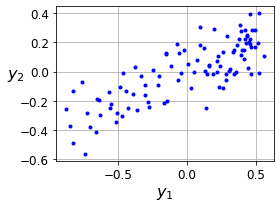

In [4]:
fig = plt.figure(figsize=(4,3))
plt.plot(X_train3D[:, 1],X_train3D[:, 2], "b.")
plt.xlabel("$y_1$", fontsize=16)
plt.ylabel("$y_2$", fontsize=16, rotation=0)
plt.grid(True)
save_fig("3D_data")
plt.show()

Or in 3D

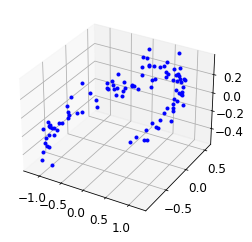

In [5]:
from mpl_toolkits import mplot3d
fig = plt.figure() 
ax = plt.axes(projection ='3d')
ax.plot3D(X_train3D[:, 0], X_train3D[:, 1], X_train3D[:, 2], 'b.')

## PCA (sckitlearn) 

In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X_train3D)


PCA(n_components=2)

In [7]:
X_pca = pca.transform(X_train3D)

Saving figure pca_plot


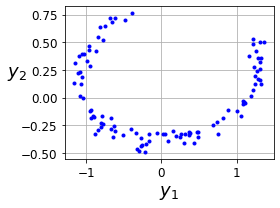

In [8]:
fig = plt.figure(figsize=(4,3))
plt.plot(X_pca[:,0], X_pca[:, 1], "b.")
plt.xlabel("$y_1$", fontsize=18)
plt.ylabel("$y_2$", fontsize=18, rotation=0)
plt.grid(True)
save_fig("pca_plot")
plt.show()

In [9]:
X_new = pca.inverse_transform(X_pca)

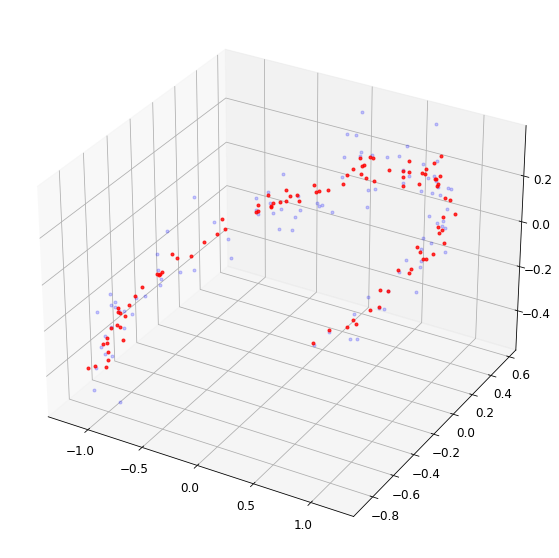

In [15]:
fig = plt.figure(figsize=(10,10)) 
ax = plt.axes(projection ='3d')
ax.plot3D(X_train3D[:, 0], X_train3D[:, 1], X_train3D[:, 2], 'b.',alpha=0.2)
ax.plot3D(X_new[:, 0], X_new[:, 1], X_new[:, 2], 'r.',alpha=0.8)

## PCA with a linear Autoencoder

A simple autoencoder projects a input vector into a vector of reduced dimension, in the encoder step, then it recovers  the input vector from this reduced vector, in the so-called **latent space**, in the decoder step.

Here we use one linear layer as encoder, and another as the output. The weights are learnt by gradient descend, making the mse as lower as possible.

Now let's build the Autoencoder...

In [9]:
np.random.seed(42)
tf.random.set_seed(42)

encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1.5))

In [10]:
history = autoencoder.fit(X_train3D, X_train3D, epochs=20)

Train on 100 samples
Epoch 1/20
100/100 [==============================] - 0s 2ms/sample - loss: 0.2050
Epoch 2/20
100/100 [==============================] - 0s 94us/sample - loss: 0.1104
Epoch 3/20
100/100 [==============================] - 0s 77us/sample - loss: 0.1406
Epoch 4/20
100/100 [==============================] - 0s 81us/sample - loss: 0.1088
Epoch 5/20
100/100 [==============================] - 0s 69us/sample - loss: 0.0359
Epoch 6/20
100/100 [==============================] - 0s 111us/sample - loss: 0.0163
Epoch 7/20
100/100 [==============================] - 0s 84us/sample - loss: 0.0071
Epoch 8/20
100/100 [==============================] - 0s 74us/sample - loss: 0.0055
Epoch 9/20
100/100 [==============================] - 0s 117us/sample - loss: 0.0061
Epoch 10/20
100/100 [==============================] - 0s 83us/sample - loss: 0.0121
Epoch 11/20
100/100 [==============================] - 0s 87us/sample - loss: 0.0096
Epoch 12/20
100/100 [==============================]

In [11]:
codings = encoder.predict(X_train3D)

Saving figure linear_autoencoder_pca_plot


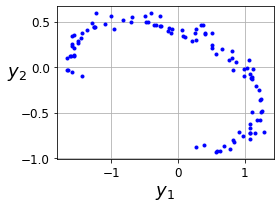

In [12]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$y_1$", fontsize=18)
plt.ylabel("$y_2$", fontsize=18, rotation=0)
plt.grid(True)
save_fig("linear_autoencoder_pca_plot")
plt.show()

# PCA for Fashion MNIST

Let's use MNIST (https://github.com/zalandoresearch/fashion-mnist):

In [13]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

## Tying weights

In PCA we tie the weights of the encoder and the decoder, by simply using the transpose of the encoder's weights as the decoder weights. For this, we need to use a custom layer.

In [14]:
class linearDenseTranspose(keras.layers.Layer):
    """ 
    linearDenseTranspose(keras.layers.Layer)
    
    It allows to use the same linear layer of the encoding in the decoder step, with the same weights.
    """
    def __init__(self, dense, **kwargs):
        self.dense = dense
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=[self.dense.input_shape[-1]],
                                      initializer="zeros")
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return (z + self.biases)

In [15]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

Flattening = keras.layers.Flatten(input_shape=[28, 28])
dense = keras.models.Sequential([keras.layers.Dense(30, input_shape=[28*28])])
encoder = keras.models.Sequential([Flattening , dense])

decoder = keras.models.Sequential([linearDenseTranspose(dense), # We use the same layer as in the encoder
                                 keras.layers.Reshape([28, 28])])

## If we want not to tie the layers, just run
#decoder = keras.models.Sequential([keras.layers.Dense(28*28, input_shape=[30]),
#                                 keras.layers.Reshape([28, 28])])
## instead, where linearDenseTranspose is not used

autoencoder = keras.models.Sequential([encoder, decoder])
autoencoder.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1.5))


In [16]:
history = autoencoder.fit(X_train, X_train, epochs=20)

Train on 55000 samples
Epoch 1/20
55000/55000 [==============================] - 3s 47us/sample - loss: 0.0295
Epoch 2/20
55000/55000 [==============================] - 2s 45us/sample - loss: 0.0199
Epoch 3/20
55000/55000 [==============================] - 2s 45us/sample - loss: 0.0174
Epoch 4/20
55000/55000 [==============================] - 3s 46us/sample - loss: 0.0164
Epoch 5/20
55000/55000 [==============================] - 2s 45us/sample - loss: 0.0160
Epoch 6/20
55000/55000 [==============================] - 2s 44us/sample - loss: 0.01590s - loss: 0.
Epoch 7/20
55000/55000 [==============================] - 2s 45us/sample - loss: 0.0158
Epoch 8/20
55000/55000 [==============================] - 2s 45us/sample - loss: 0.0158
Epoch 9/20
55000/55000 [==============================] - 2s 45us/sample - loss: 0.0158
Epoch 10/20
55000/55000 [==============================] - 2s 45us/sample - loss: 0.0158
Epoch 11/20
55000/55000 [==============================] - 2s 45us/sample - loss: 0

## Show reconstructions

In [17]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

Saving figure reconstruction_plot


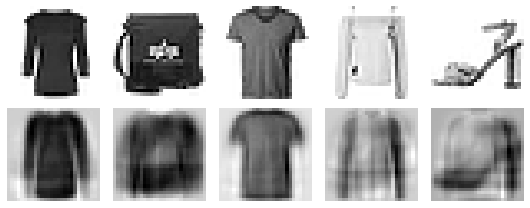

In [18]:
show_reconstructions(autoencoder)
save_fig("reconstruction_plot")

In [19]:
# Visualizing Fashion MNIST

In [20]:
np.random.seed(42)

from sklearn.manifold import TSNE

X_valid_compressed = encoder.predict(X_valid)
print(X_valid_compressed.shape)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

(5000, 30)


Saving figure fashion_mnist_visualization_plot


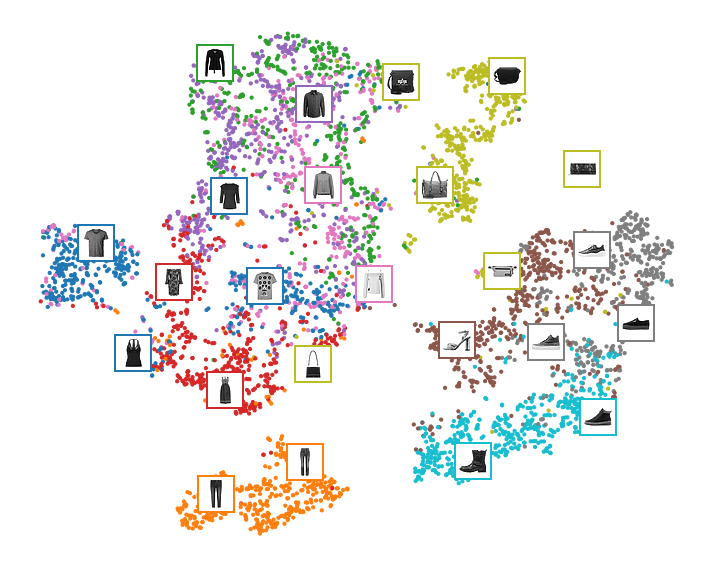

In [21]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
save_fig("fashion_mnist_visualization_plot")
plt.show()

## Data Visualization with PCA

In [40]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

Flattening = keras.layers.Flatten(input_shape=[28, 28])
dense = keras.models.Sequential([keras.layers.Dense(2, input_shape=[28*28])])
encoder2D = keras.models.Sequential([Flattening , dense])

decoder2D = keras.models.Sequential([linearDenseTranspose(dense), # We use the same layer as in the encoder
                                 keras.layers.Reshape([28, 28])])

## If we want not to tie the layers, just run
#decoder = keras.models.Sequential([keras.layers.Dense(28*28, input_shape=[30]),
#                                 keras.layers.Reshape([28, 28])])
## instead, where linearDenseTranspose is not used

autoencoder2D = keras.models.Sequential([encoder2D, decoder2D])
autoencoder2D.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1.5))
history = autoencoder2D.fit(X_train, X_train, epochs=20)

Train on 55000 samples
Epoch 1/20
55000/55000 [==============================] - 2s 45us/sample - loss: 0.0526
Epoch 2/20
55000/55000 [==============================] - 2s 42us/sample - loss: 0.0468
Epoch 3/20
55000/55000 [==============================] - 2s 41us/sample - loss: 0.0467
Epoch 4/20
55000/55000 [==============================] - 2s 41us/sample - loss: 0.0466
Epoch 5/20
55000/55000 [==============================] - 2s 41us/sample - loss: 0.0466
Epoch 6/20
55000/55000 [==============================] - 2s 41us/sample - loss: 0.0466
Epoch 7/20
55000/55000 [==============================] - 2s 41us/sample - loss: 0.0466
Epoch 8/20
55000/55000 [==============================] - 2s 40us/sample - loss: 0.0466
Epoch 9/20
55000/55000 [==============================] - 2s 41us/sample - loss: 0.0466
Epoch 10/20
55000/55000 [==============================] - 2s 41us/sample - loss: 0.0466
Epoch 11/20
55000/55000 [==============================] - 2s 41us/sample - loss: 0.0466
Epoch 1

Saving figure fashion_mnist_visualization_plot


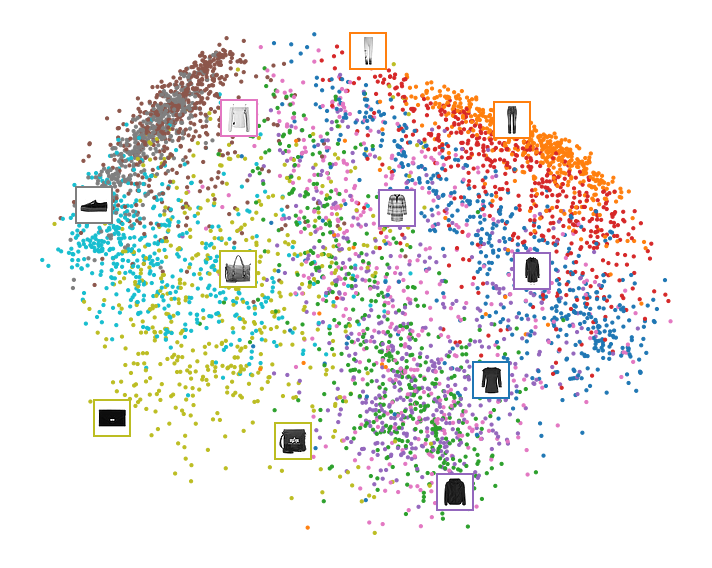

In [41]:

X_valid_2D = encoder2D.predict(X_valid)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
save_fig("fashion_mnist_visualization_plot")
plt.show()